# Deep Learing Approach For Relation Extractions

This notebook is divided into four sections:
- Data Preprocessing: Processes the annotated data and extracts the sentences with entities.
- Model Training: Trains and evaluates a BERT base model to predict relation type.
- Model Testing: Uses the trained models to predict relationships between entities in the preprocessed dataset.
- Pre-loaded Model Testing: Uploads an existing model weights to test with an input sentence.

# Part I: Data Preprocessing
## Load the dataset and preprocess
This part is mainly to upload the dataset.json file and extract sentences with entities from the file. Further, we are uploading BertTokenizer and mapping the labels to relations.

In [ ]:
import json
import spacy
import pandas as pd


# load the JSON dataset and split into train and test sets

with open("dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# first 400 documents for train and 100 for test as for ML model
train_data = data[:400]
test_data = data[400:]

# extract relation examples from each document

nlp = spacy.load("en_core_web_sm")

def find_sentence_for_relation(doc_text, entities, relation):
    """
    Given a document's text, its entities, and one relation,
    get the sentence that contains both entity mentions.
    If not found, return the whole document text.
    """
    doc = nlp(doc_text)
    ent1 = entities[relation['arg1']]
    ent2 = entities[relation['arg2']]
    for sent in doc.sents:
        if sent.start_char <= ent1['start'] and sent.end_char >= ent1['end'] and \
           sent.start_char <= ent2['start'] and sent.end_char >= ent2['end']:
            return sent.text, ent1, ent2
    return doc_text, ent1, ent2

def extract_relation_examples(dataset):
    """
    For each document in the dataset, extract relation examples by:
      - Finding the sentence containing both entities in each relation.
      - Marking the entities with special tokens.
    Returns a list of dictionaries with keys:
      "sentence": the marked sentence,
      "relation": the relation label.
    """
    relation_examples = []
    for doc in dataset:
        text = doc["text"]
        # map from entity IDs to  entity dictionary
        entities = { ent["entity_id"]: ent for ent in doc["entities"] }
        for rel in doc["relations"]:
            sent_text, ent1, ent2 = find_sentence_for_relation(text, entities, rel)
            # marking the first and second entities with E1 and E2
            marked_sentence = sent_text
            marked_sentence = marked_sentence.replace(ent1["text"], f"[E1]{ent1['text']}[/E1]", 1)
            marked_sentence = marked_sentence.replace(ent2["text"], f"[E2]{ent2['text']}[/E2]", 1)
            relation_examples.append({
                "sentence": marked_sentence,
                "relation": rel["type"]
            })
    return relation_examples

# extract candidate relations
train_examples = extract_relation_examples(train_data)
test_examples = extract_relation_examples(test_data)

# convert the examples to dfs
train_df = pd.DataFrame(train_examples)
test_df = pd.DataFrame(test_examples)

print("Train examples (first 5 rows):")
print(train_df.head())
print(f'The shape of train dataset: {train_df.shape}')
print("\nTest examples (first 5 rows):")
print(test_df.head())
print(f'The shape of test dataset: {test_df.shape}')



Train examples (first 5 rows):
                                            sentence    relation
0  Landsbergen's advocacy of  [E1]analytical inve...    USED-FOR
1  A  [E2]parser MDCC[/E2]  is presented which im...    USED-FOR
2  so as to display the  [E2]derivational history...  FEATURE-OF
3  A  parser MDCC  is presented which implements ...  FEATURE-OF
4  This paper reports a completed stage of ongoin...    USED-FOR
The shape of train dataset: (5161, 2)

Test examples (first 5 rows):
                                            sentence  relation
0  It is well-known that diversity among [E1]base...  USED-FOR
1  Using [E1]pairwise constraints[/E1] for [E2]en...  USED-FOR
2  It is well-known that diversity among base cla...     COREF
3  It is well-known that diversity among base cla...     COREF
4  It is well-known that diversity among [E1][E2]...     COREF
The shape of test dataset: (1233, 2)


In [ ]:
from collections import Counter

#count relations in train dataset
relation_counts = Counter(train_df["relation"])
print("Relation Distribution in Training Data:")
for rel, count in relation_counts.items():
    print(f"  {rel}: {count}")

Relation Distribution in Training Data:
  USED-FOR: 1962
  FEATURE-OF: 214
  COREF: 1364
  CONJUNCTION: 455
  PART-OF: 226
  HYPONYM-OF: 353
  COMPARE: 203
  EVALUATE-FOR: 384


In [ ]:
#count relations in test dataset

relation_counts = Counter(test_df["relation"])
print("Relation Distribution in Test Data:")
for rel, count in relation_counts.items():
    print(f"  {rel}: {count}")

Relation Distribution in Test Data:
  USED-FOR: 475
  COREF: 311
  PART-OF: 44
  COMPARE: 31
  EVALUATE-FOR: 70
  CONJUNCTION: 128
  HYPONYM-OF: 124
  FEATURE-OF: 50


In [ ]:
# import Bert tokenizer
import tensorflow as tf
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# create labels for relations
relations_list = sorted(train_df["relation"].unique())
label2id = {label: idx for idx, label in enumerate(relations_list)}
id2label = {idx: label for label, idx in label2id.items()}
num_labels = len(label2id)

print("Relation classes:", relations_list)
print("label2id:", label2id)
print("Total labels:", num_labels)

Relation classes: ['COMPARE', 'CONJUNCTION', 'COREF', 'EVALUATE-FOR', 'FEATURE-OF', 'HYPONYM-OF', 'PART-OF', 'USED-FOR']
label2id: {'COMPARE': 0, 'CONJUNCTION': 1, 'COREF': 2, 'EVALUATE-FOR': 3, 'FEATURE-OF': 4, 'HYPONYM-OF': 5, 'PART-OF': 6, 'USED-FOR': 7}
Total labels: 8


# PART II: Model Training

In this part we are loading the packages and creating classes and functions to train the model and assign hyperparameters.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import (
    BertTokenizer,
    BertModel,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    AdamW
)
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import Dataset, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader


# custom metrics function with macro F1 focus instead of accuracy --> imbalanced dataset
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # classification report
    cls_report = classification_report(
        labels, preds,
        target_names=list(label2id.keys()),
        output_dict=True,
        zero_division=0
    )

    # macro metrics for imbalanced data and include per-class f1
    additional_metrics = {
        f'f1_{cls}': metrics['f1-score']
        for cls, metrics in cls_report.items()
        if isinstance(metrics, dict) and cls not in ['macro avg', 'weighted avg']
    }

    return {
        'f1_macro': cls_report['macro avg']['f1-score'],
        'precision_macro': cls_report['macro avg']['precision'],
        'recall_macro': cls_report['macro avg']['recall'],
        'f1_weighted': cls_report['weighted avg']['f1-score'],
        **additional_metrics
    }

# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class EnhancedBertClassifier(nn.Module):
    def __init__(self, num_labels, dropout_rate=0.3,
                 class_weights=None, use_focal=False):
        super().__init__()

        # pre-trained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size

        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_labels)
        )

        # focal loss function
        self.use_focal = use_focal
        if use_focal:
            self.loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)
        else:
            self.loss_fn = nn.CrossEntropyLoss(
                weight=class_weights,
                label_smoothing=0.1  # Added label smoothing
            )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        # mean pooling of all tokens instead of CLS
        last_hidden_state = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        mean_pooled = torch.sum(last_hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

        logits = self.classifier(mean_pooled)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return (loss, logits) if loss is not None else logits

# dataset class with entity markers
class RelationDataset(Dataset):
    def __len__(self):
        return len(self.df)

    def __init__(self, df, tokenizer, label2id, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = self._add_entity_markers(row["sentence"])
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.label2id[row["relation"]], dtype=torch.long)
        }

    def _add_entity_markers(self, text):
        # entity mark correction
        return text.replace("[E1]", "<e1>").replace("[/E1]", "</e1>").replace("[E2]", "<e2>").replace("[/E2]", "</e2>")


# create label2id mapping
label2id = {label: idx for idx, label in enumerate(sorted(train_df['relation'].unique()))}
train_dataset = RelationDataset(train_df, tokenizer, label2id)
test_dataset = RelationDataset(test_df, tokenizer, label2id)

# initialize class weights
train_labels = train_df['relation'].map(label2id).values
classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPUs
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# initialize model with focal loss
model = EnhancedBertClassifier(
    num_labels=num_labels,
    dropout_rate=0.3,
    class_weights=class_weights,
    use_focal=True
)

# stratified batch sampler
class StratifiedBatchSampler:
    def __init__(self, labels, batch_size, shuffle=True):
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

        label_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)

        self.batches = []
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)
            num_batches = len(indices) // batch_size
            self.batches += [indices[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

        if shuffle:
            np.random.shuffle(self.batches)

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

# training args with gradient clipping and optimized LR and other hyperparameters
training_args = TrainingArguments(
    output_dir="./improved_bert_relation",
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    max_steps=10000,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none"
)

# custom trainer with stratified sampling
class BalancedTrainer(Trainer):
    def get_train_dataloader(self):
        labels = [item['labels'].item() for item in self.train_dataset]
        sampler = StratifiedBatchSampler(
            labels=labels,
            batch_size=self.args.train_batch_size,
            shuffle=True
        )
        return DataLoader(
            self.train_dataset,
            batch_sampler=sampler,
            collate_fn=self.data_collator,
            pin_memory=True
        )

# trainer with early stopping (3)
trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train and Evaluate
trainer.train()
results = trainer.evaluate()
print("Evaluation results:", results)

Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,F1 Compare,F1 Conjunction,F1 Coref,F1 Evaluate-for,F1 Feature-of,F1 Hyponym-of,F1 Part-of,F1 Used-for
200,1.740000,1.692682,0.183378,0.217664,0.223129,0.452024,0.000000,0.000000,0.781955,0.027778,0.000000,0.000000,0.000000,0.657291
400,1.614500,1.425118,0.250569,0.304074,0.318587,0.439051,0.000000,0.567308,0.847176,0.185235,0.000000,0.000000,0.000000,0.404834
600,1.058300,0.973316,0.532116,0.572472,0.533376,0.722915,0.526316,0.873563,0.870769,0.644737,0.000000,0.541176,0.000000,0.800370
800,0.611700,0.781230,0.589864,0.675334,0.613774,0.723137,0.480000,0.912698,0.898026,0.371968,0.276923,0.780083,0.303030,0.696187
1000,0.301100,0.601865,0.727154,0.734152,0.744282,0.823566,0.608696,0.883212,0.907692,0.681818,0.534884,0.764706,0.580645,0.855580
1200,0.170100,0.530314,0.741489,0.750689,0.756372,0.835086,0.666667,0.906883,0.906498,0.693182,0.487179,0.801762,0.601942,0.867804
1400,0.045100,0.712500,0.744944,0.774875,0.752040,0.838710,0.655172,0.888889,0.910828,0.805970,0.555556,0.724490,0.536232,0.882414
1600,0.021500,0.742799,0.744302,0.765771,0.748539,0.835618,0.732394,0.909836,0.896989,0.731707,0.410959,0.801762,0.597701,0.873065
1800,0.006900,0.775960,0.758399,0.777928,0.766556,0.840727,0.727273,0.902439,0.898148,0.823529,0.625000,0.714286,0.492063,0.884454
2000,0.004700,0.635288,0.764840,0.748076,0.805138,0.843112,0.619048,0.916996,0.899225,0.785714,0.582524,0.792793,0.654867,0.867550


Evaluation results: {'eval_loss': 0.7293816804885864, 'eval_f1_macro': 0.7906903283289014, 'eval_precision_macro': 0.7921209127189834, 'eval_recall_macro': 0.7939152997476326, 'eval_f1_weighted': 0.8606473745519627, 'eval_f1_COMPARE': 0.7164179104477612, 'eval_f1_CONJUNCTION': 0.92, 'eval_f1_COREF': 0.9076682316118936, 'eval_f1_EVALUATE-FOR': 0.7887323943661971, 'eval_f1_FEATURE-OF': 0.64, 'eval_f1_HYPONYM-OF': 0.8198198198198198, 'eval_f1_PART-OF': 0.6451612903225806, 'eval_f1_USED-FOR': 0.887722980062959, 'eval_runtime': 3.3543, 'eval_samples_per_second': 367.584, 'eval_steps_per_second': 11.627, 'epoch': 40.0}


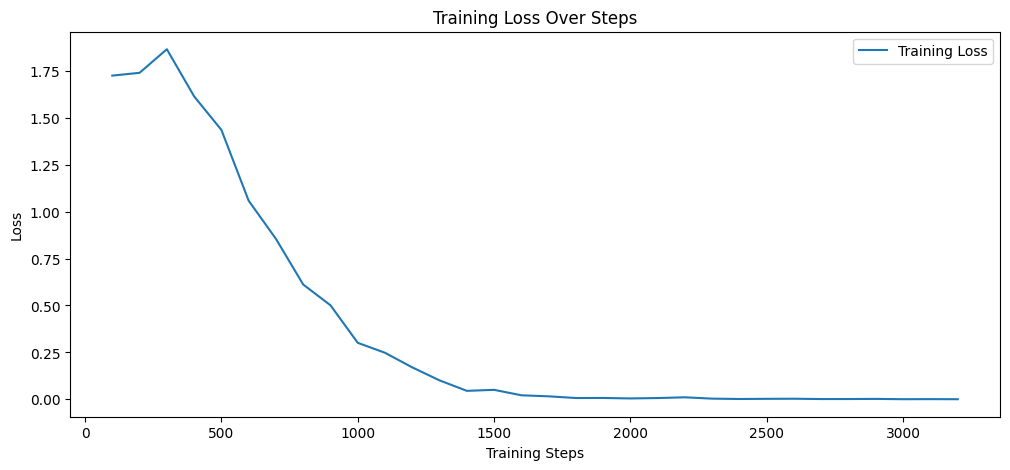

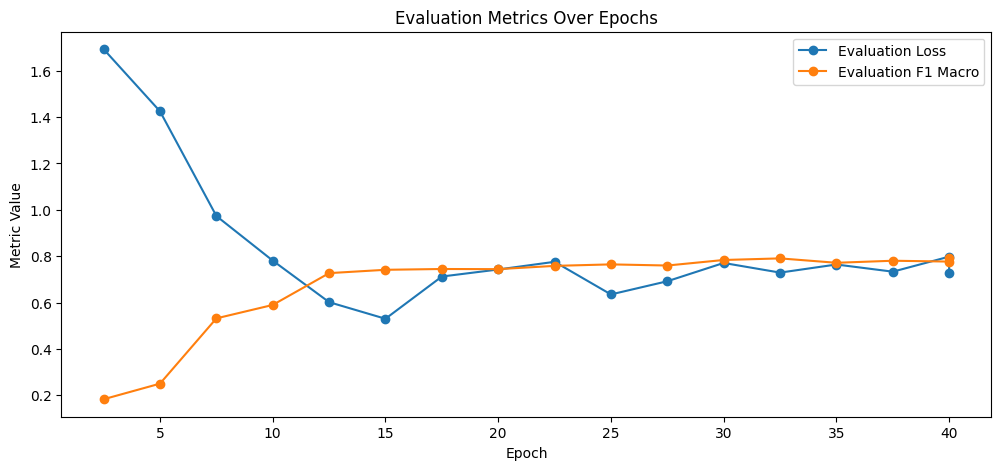

In [ ]:
import matplotlib.pyplot as plt

# log history to df
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

# sort loss by step
train_logs = df_logs[df_logs['loss'].notnull() & df_logs['step'].notnull()]
train_logs = train_logs.sort_values(by='step')

# df of eval logs
eval_logs = df_logs[df_logs['eval_loss'].notnull()]
if 'epoch' in eval_logs.columns:
    eval_logs = eval_logs.sort_values(by='epoch')

# training loss over training steps
plt.figure(figsize=(12, 5))
plt.plot(train_logs['step'], train_logs['loss'], label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
#plt.savefig("training_loss.png")
plt.show()


# evaluation metrics over epochs
plt.figure(figsize=(12, 5))
if 'epoch' in eval_logs.columns:
    plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label="Evaluation Loss", marker='o')
else:
    plt.plot(eval_logs.index, eval_logs['eval_loss'], label="Evaluation Loss", marker='o')

# plot macro F1
if 'eval_f1_macro' in eval_logs.columns:
    if 'epoch' in eval_logs.columns:
        plt.plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], label="Evaluation F1 Macro", marker='o')
    else:
        plt.plot(eval_logs.index, eval_logs['eval_f1_macro'], label="Evaluation F1 Macro", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
#plt.savefig("evaluation_metrics.png")
plt.show()


# save the df for further analysis
#df_logs.to_csv("trainer_log_history.csv", index=False)


# Part III: Model testing
## Test I
In this part we are testing the model inputing a snetence with entities and creating a function to preprocess the input sentence.

In [ ]:
# initialize a function with input sentence and pre-processing and parameters
def predict_relation(input_sentence, model, tokenizer, label2id, max_length=128):
    processed_sentence = input_sentence.replace("[E1]", "<e1>").replace("[/E1]", "</e1>")\
                                        .replace("[E2]", "<e2>").replace("[/E2]", "</e2>")
    encoding = tokenizer(
        processed_sentence,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    # Retrieve device from the model and move tensors
    device = next(model.parameters()).device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=encoding["input_ids"], attention_mask=encoding["attention_mask"])
        logits = outputs if not isinstance(outputs, tuple) else outputs[1]
    predicted_label_id = torch.argmax(logits, dim=1).item()
    id2label = {v: k for k, v in label2id.items()}
    predicted_label = id2label[predicted_label_id]
    print("Input Sentence:", input_sentence)
    print("Processed Sentence:", processed_sentence)
    print("Predicted Relation Label:", predicted_label)
    return predicted_label

# first test check
example_sentence = "[E1]Traditional statistical methods[/E1] often perform worse than [E2]deep learning models[/E2] on complex tasks."
predict_relation(example_sentence, model, tokenizer, label2id)

Input Sentence: [E1]Traditional statistical methods[/E1] often perform worse than [E2]deep learning models[/E2] on complex tasks.
Processed Sentence: <e1>Traditional statistical methods</e1> often perform worse than <e2>deep learning models</e2> on complex tasks.
Predicted Relation Label: COMPARE


'COMPARE'

### TEST II
In this part we are testing another relation type to check that the model does not just predict one class.

In [ ]:
# second test check
example_sentence2 = "[E1]The hippocampus[/E1] is a critical component of the [E2]limbic system[/E2] in the brain."
predict_relation(example_sentence2, model, tokenizer, label2id)

Input Sentence: [E1]The hippocampus[/E1] is a critical component of the [E2]limbic system[/E2] in the brain.
Processed Sentence: <e1>The hippocampus</e1> is a critical component of the <e2>limbic system</e2> in the brain.
Predicted Relation Label: PART-OF


'PART-OF'

Finally, saving the model.

In [ ]:
# save model --> 420 mb
torch.save(model.state_dict(), "model_weights.pt")

# PART IV: Test with a Pre-Loaded Model

In this part you can load the model from the drive and check the parameters.
After that, initialize a function to preprocess and predict relations and input a sentence with entity tags to predict reation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#first initialize the model and then load the weights
model = EnhancedBertClassifier(num_labels=num_labels, dropout_rate=0.3, class_weights=class_weights, use_focal=True)
model.load_state_dict(torch.load("model_weights.pt", map_location=device))
model.to(device)
model.eval()

<ipython-input-12-590474da01b5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pt", map_location=device))


EnhancedBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
# initialize a function again (if not intialized earlier) with input sentence and pre-processing and parameters
def predict_relation(input_sentence, model, tokenizer, label2id, max_length=128):
    processed_sentence = input_sentence.replace("[E1]", "<e1>").replace("[/E1]", "</e1>")\
                                        .replace("[E2]", "<e2>").replace("[/E2]", "</e2>")
    encoding = tokenizer(
        processed_sentence,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    # retrieve device from the model and move tensors
    device = next(model.parameters()).device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=encoding["input_ids"], attention_mask=encoding["attention_mask"])
        logits = outputs if not isinstance(outputs, tuple) else outputs[1]
    predicted_label_id = torch.argmax(logits, dim=1).item()
    id2label = {v: k for k, v in label2id.items()}
    predicted_label = id2label[predicted_label_id]
    print("Input Sentence:", input_sentence)
    print("Processed Sentence:", processed_sentence)
    print("Predicted Relation Label:", predicted_label)
    return predicted_label

In [ ]:
# input a sentence with entity tags to test
example_sentence = "Sentence"
predict_relation(example_sentence, model, tokenizer, label2id)